# 1D kinematic driver with time-dependent aerosol injection

Author: Jatan Buch (v1, 240424) || (v2, 240429) || (v3, 240521) || (v4, 240916)

In [1]:
from case_files.settings_time import Settings 
from case_files.simulation_sd_update import Simulation
import numpy as np
import xarray
from tqdm import tqdm
from PySDM.initialisation.equilibrate_wet_radii import equilibrate_wet_radii

from PySDM import Formulae
from PySDM.initialisation.spectra import Lognormal
from PySDM.physics import si
from PySDM.exporters import NetCDFExporter_1d
from collections import namedtuple

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import matplotlib.path as mpltPath
from utils.plot_params_mpl39 import params
import matplotlib.pylab as pylab
import seaborn as sns
pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']
from utils.plot_rates import plot_ax

%matplotlib inline
%config IPython.matplotlib.backend = 'retina'
%config InlineBackend.figure_format = 'retina'

sav_file_path= "/Users/hyfives-lamont/Desktop/cloud_seeding/sav_files/time_dep_seeding/run_1D_output_files/"
sav_plt_path= "/Users/hyfives-lamont/Desktop/cloud_seeding/plots/time_dep_seeding/run_1D_plots/"

## Case setup

In [2]:
common_params = {
    "t_max": 60 * si.minutes,
    "n_sd_per_mode": (32, 4),
    "aerosol_modes_by_kappa": {
            .3: Lognormal(
                        norm_factor= 10 / si.cm ** 3,
                        m_mode= 1E2 * si.nm,
                        s_geom=1.4
                ),
            .85: Lognormal(
                        norm_factor= 0.1 / si.cm ** 3,
                        m_mode= 1 * si.um,
                        s_geom=1.4
                ),
            },
    "dt": 5 * si.s,
    "dz": 50 * si.m,
    "p0": 990 * si.hPa,
    "z_part": ((0., 1.), (0., 0.25)),
    #"n_seed_sds": 1, # use this for injecting multiple seeds in delta mode
    "r_seed": 1 * si.um,
    "kappa_seed": 0.85,
    "int_inj_rate": 100 / si.cm ** 3,
    "seed_z_part": (0., 0.25),
    "save_spec_and_attr_times": [0.0, 300.0, 600.0, 900.0, 1200.0, 1800.0, 2700.0],
}

In [3]:
rate_unit = "s$^{-1}$ kg$^{-1}$"
contour_lev = [.4]
rho_times_w= 2 * si.kg/si.m**3 * si.m/si.s

kwargs = {
    'coll_rate': {'cmin': 100, 'cmax': 1e6, 'var': 'collision_rate',   'qlabel': f'collision rate [{rate_unit}]', 'clog': True}, 
    'coal_rate': {'cmin': 100, 'cmax': 1e6, 'var': 'coalescence_rate', 'qlabel': f'coalescence rate [{rate_unit}]', 'clog': True},
}
contour_args = {
    'contour_var1': 'cloud water mixing ratio', 'contour_lvl1': contour_lev,
    'contour_var2': 'rain water mixing ratio', 'contour_lvl2': contour_lev
}

def fig_ax(nrows= 1, ncols= 1):
    return plt.subplots(nrows= nrows, ncols= ncols, figsize=(8*ncols,6*nrows))

def plot_spectra(ax, stgs, oupt, key_arg, plt_arg, t_sel):
    spct_step = common_params['save_spec_and_attr_times'].index(t_sel)
    ax.step(stgs[key_arg].r_bins_edges[0:-1] / si.um, oupt[key_arg].products[plt_arg].mean(axis=0)[:,spct_step] / si.cm**3, label= r't = %d s'%t_sel)
    ax.set_xscale('log')
    ax.set_xlim([1e-2, 1e4])
    ax.set_xlabel(r"particle radius ($\mu$m)")
    if plt_arg == 'wet spectrum':
        ax.set_ylabel('dN / dlnr  (g / m$^3$)')
    elif plt_arg == 'dry spectrum':
        ax.set_ylabel('dN / dlnr  (cm$^{-3}$)')
    elif plt_arg == 'dvdlnr':
        ax.set_ylabel('dm / dlnr  (g / m$^3$)')

## Stochastic averaging

In [4]:
n_runs= 10
sav_flag= False

output = {}
settings = {}
simulation = {}
rain_xarr = {}
surface_rain= {}

np.random.seed(67) #87, 121
rho_times_w_arr= np.array([2]) * si.kg/si.m**3 * si.m/si.s
sfile_name=  "_n1_10_r1_0.1_nsdbkg_32_injrate_100_rsd_1_nsdseed_4_zseed_0.25_tseed_agg_60" #50_70_100_150_200_250_300  #"_n1_10_r1_0.1_benchmark"

r_id= 0
pbar = tqdm(total= n_runs)
while r_id < n_runs:
    for rho_times_w in (rho_times_w_arr):
        try:
            key = f"rhow={rho_times_w}_run={r_id}"
            settings[key] = Settings(
                **common_params,
                formulae= Formulae(seed= np.random.randint(1000)),
                rho_times_w_1=rho_times_w,
                precip= True
                )
            simulation[key] = Simulation(settings[key])
            output[key]= simulation[key].stepwise_sd_update(seed_step= [60], seeding_type= 'aggregate') #50, 70, 100, 150, 200, 250, 300
            rain_xarr[key]= xarray.DataArray(data= output[key].products['rain water mixing ratio'],
                            dims=["z", "t"],
                            coords=dict(
                                t=(["t"], output[key].products['t'],),
                                z=(["z"], output[key].products['z'],),)
                            )
            pbar.update(1)
            r_id += 1
        except:
            continue
pbar.close()

for rho_times_w in (rho_times_w_arr):
    key = f"rhow={rho_times_w}"
    surface_rain[key]= xarray.concat([rain_xarr[key + "_run=" + str(i)] for i in range(n_runs)], dim="run")
    surface_rain[key]= surface_rain[key].assign_coords(run=range(n_runs))

if sav_flag:
    surface_rain[key].to_netcdf(sav_file_path + 'surface_rain_' + key + sfile_name + ".nc") 

  0%|          | 0/10 [00:00<?, ?it/s]/Users/hyfives-lamont/Desktop/cloud_seeding/PySDM/PySDM/backends/numba.py:46: UserWarning: Disabling Numba threading due to ARM64 CPU (atomics do not work yet)
  warnings.warn(
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
 10%|█         | 1/10 [00:51<07:43, 51.50s/it]/Users/hyfives-lamont/Desktop/cloud_seeding/PySDM/PySDM/backends/numba.py:46: UserWarning: Disabling Numba threading due to ARM64 CPU (atomics do not work yet)
  warnings.warn(
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
 20%|██        | 2/10 [01:05<03:53, 29.23s/it]/Users/hyfives-lamont/Desktop/cloud_seeding/PySDM/PySDM/backends/numba.py:46: UserWarning: Disabling Numba threading due to ARM64 CPU (atomics do not work yet)
  warnings.warn(
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
 30%|███       | 3/10 [01:14<02:20, 20.11s/it]/Users/hyfives-lamont/Desktop/cloud

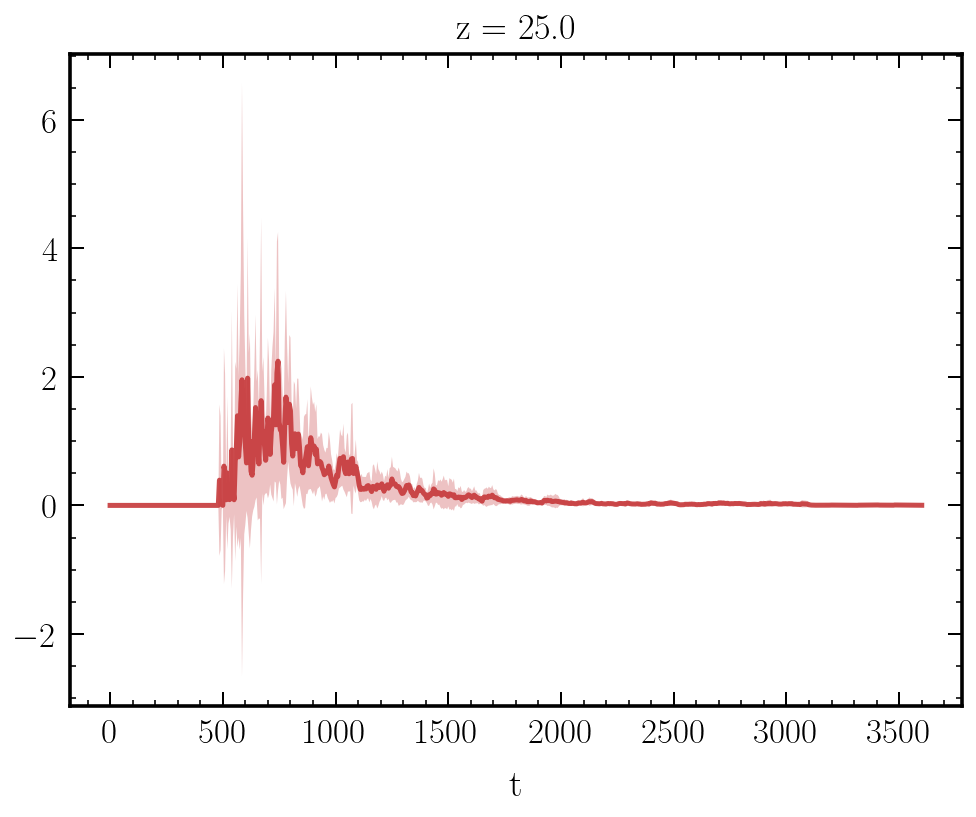

In [5]:
fig, ax= plt.subplots(1, 1, figsize=(8, 6))
surface_rain[key].sel(z= 25).mean(dim= "run").plot(ax= ax)
ax.fill_between(surface_rain[key].t, surface_rain[key].sel(z= 25).mean(dim= "run") + surface_rain[key].sel(z= 25).std(dim= "run"), \
                                        surface_rain[key].sel(z= 25).mean(dim= "run") - surface_rain[key].sel(z= 25).std(dim= "run"), alpha= 0.3)

In [6]:
surface_rain[key].sel(z= 25).sum(dim= "t").mean(dim= "run")

<xarray.DataArray ()>
array(138.93459819)
Coordinates:
    z        float64 25.0

In [7]:
surface_rain[key].sel(z= 25).sum(dim= "t")

<xarray.DataArray (run: 10)>
array([149.85761131, 142.15138735, 142.98528092, 133.63364106,
       120.85509207, 143.23663437, 161.32835051, 117.49950463,
       159.23290636, 118.56557329])
Coordinates:
    z        float64 25.0
  * run      (run) int64 0 1 2 3 4 5 6 7 8 9

## Plotting

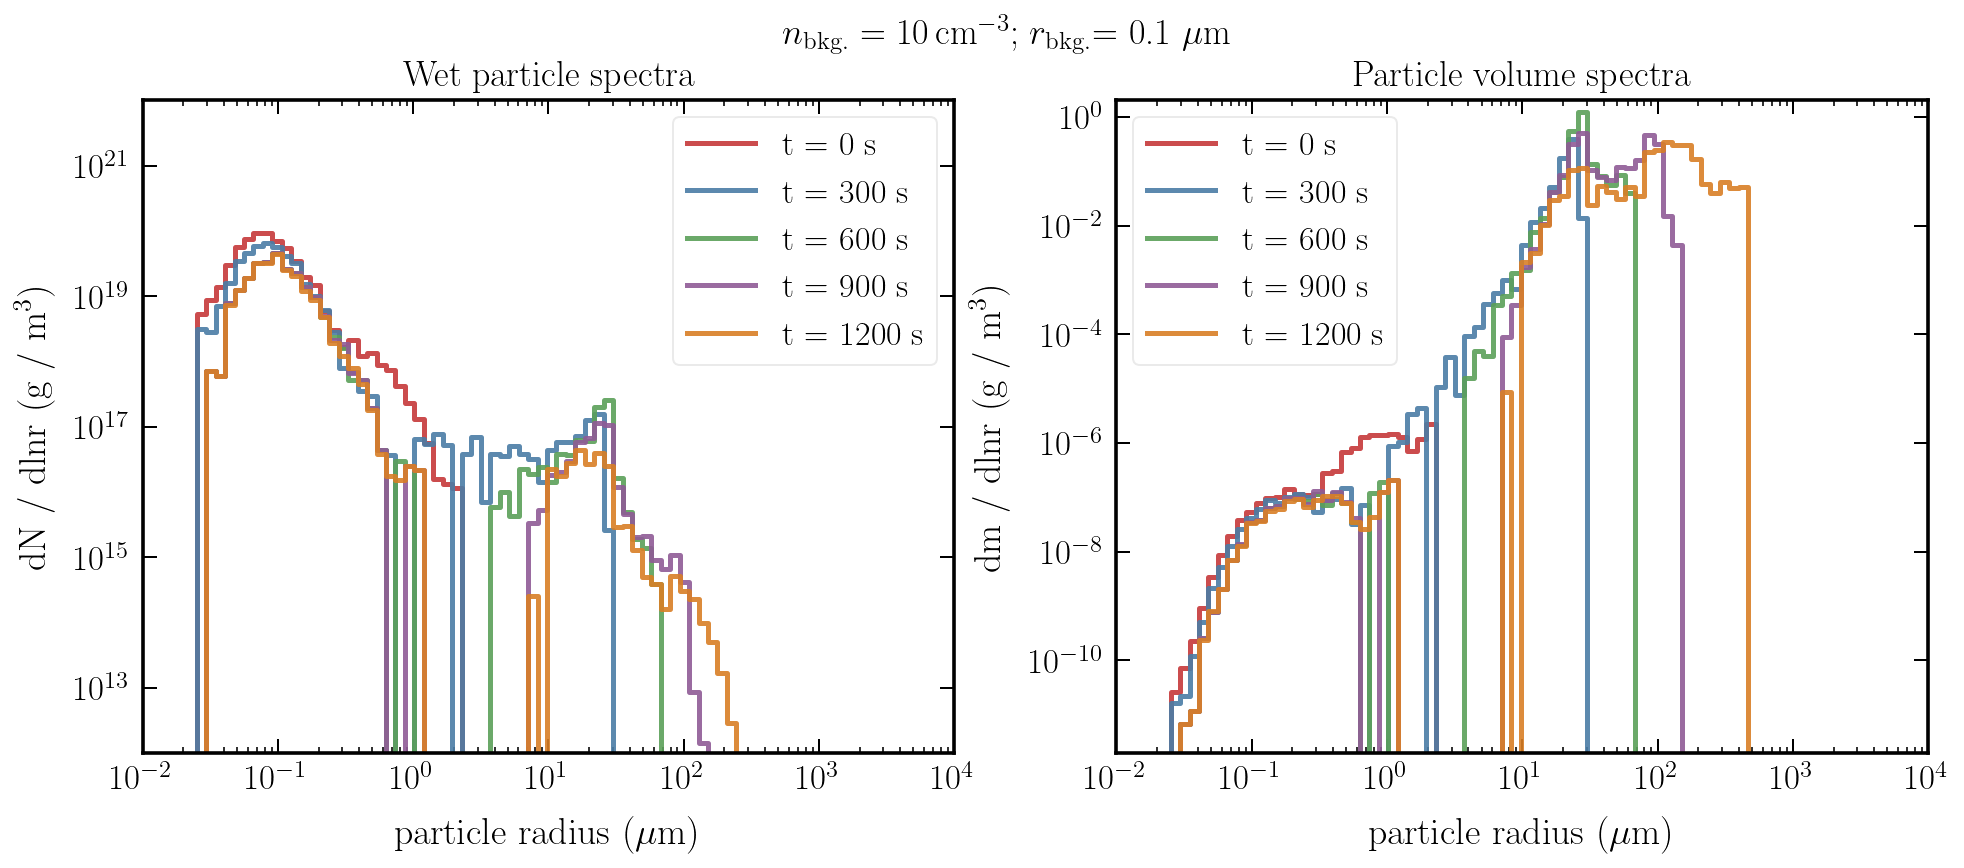

In [10]:
fig, ax= fig_ax(nrows= 1, ncols= 2)
plot_spectra(ax[0], stgs= settings, oupt= output, key_arg= f"rhow={rho_times_w}_run={2}", plt_arg= 'wet spectrum', t_sel= 0.0)
plot_spectra(ax[0], stgs= settings, oupt= output, key_arg= f"rhow={rho_times_w}_run={2}", plt_arg= 'wet spectrum', t_sel= 300.0)
plot_spectra(ax[0], stgs= settings, oupt= output, key_arg= f"rhow={rho_times_w}_run={2}", plt_arg= 'wet spectrum', t_sel= 600.0)
plot_spectra(ax[0], stgs= settings, oupt= output, key_arg= f"rhow={rho_times_w}_run={2}", plt_arg= 'wet spectrum', t_sel= 900.0)
plot_spectra(ax[0], stgs= settings, oupt= output, key_arg= f"rhow={rho_times_w}_run={2}", plt_arg= 'wet spectrum', t_sel= 1200.0)

ax[0].set_yscale('log');
ax[0].set_ylim([1e12, 1e22]);
ax[0].legend(frameon= True);
ax[0].set_title(r'Wet particle spectra');

plot_spectra(ax[1], stgs= settings, oupt= output, key_arg= f"rhow={rho_times_w}_run={2}", plt_arg= 'dvdlnr', t_sel= 0.0)
plot_spectra(ax[1], stgs= settings, oupt= output, key_arg= f"rhow={rho_times_w}_run={2}", plt_arg= 'dvdlnr', t_sel= 300.0)
plot_spectra(ax[1], stgs= settings, oupt= output, key_arg= f"rhow={rho_times_w}_run={2}", plt_arg= 'dvdlnr', t_sel= 600.0)
plot_spectra(ax[1], stgs= settings, oupt= output, key_arg= f"rhow={rho_times_w}_run={2}", plt_arg= 'dvdlnr', t_sel= 900.0)
plot_spectra(ax[1], stgs= settings, oupt= output, key_arg= f"rhow={rho_times_w}_run={2}", plt_arg= 'dvdlnr', t_sel= 1200.0)
ax[1].set_yscale('log');
ax[1].set_ylim([2e-12, 2]);
ax[1].legend(frameon= True);
ax[1].set_title(r'Particle volume spectra');
#fig.suptitle(r'$n_{\rm bkg.} = 10 \, {\rm cm}^{-3}$; $r_{\rm bkg.}$= 0.1 $\mu {\rm m}$', fontsize= 18);
fig.suptitle(r'$r_{\rm seed}$= 1 $\mu {\rm m}$ ; $N_{\rm SD}$ = %d; '%simulation['rhow=2.0_run=0'].n_seed_sds + 
                        r'$t_{\rm seed}= 5 \, {\rm mins}$; $a_{\rm int. inj. rate} = %d \, {\rm cm}^{-3}$'%np.ceil(settings['rhow=2.0_run=0'].int_inj_rate * 1e-6), fontsize= 18);
if sav_flag:
    plt.savefig(sav_plt_path + 'spectra_plot_seeding' + sfile_name + '.pdf', bbox_inches='tight', dpi= 300);

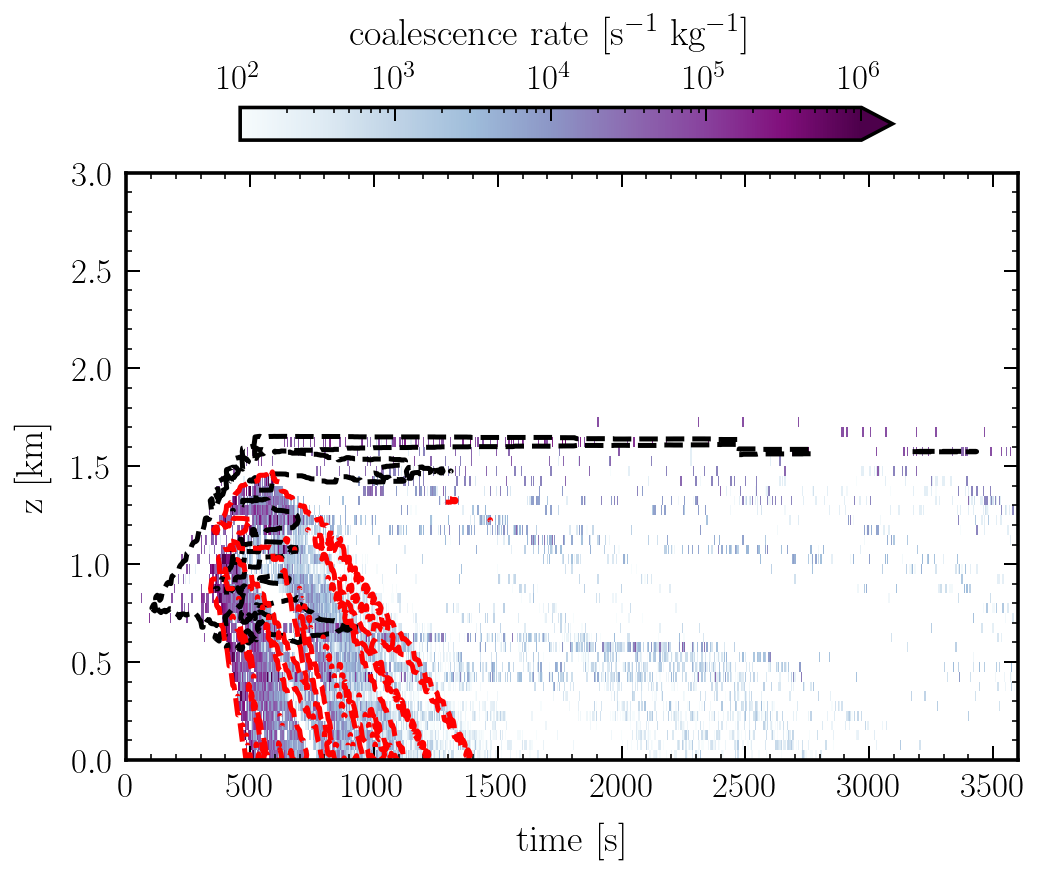

In [18]:
fig, axes = fig_ax()
plot_ax(axes, output= output[f"rhow={rho_times_w}_run={0}"].products, **contour_args, **kwargs['coal_rate'])
if sav_flag:
    plt.savefig(sav_plt_path + 'coal_rate' + sfile_name + '.pdf', bbox_inches='tight', dpi= 300);

In [60]:
surface_rain_bench= xarray.open_dataarray("~/Desktop/cloud_seeding/sav_files/surface_rain_rhow=2.0_n1_10_r1_0.1_nsd_32.nc")
surface_rain_seeded= xarray.open_dataarray(sav_file_path + 'surface_rain_' + key + sfile_name + '.nc')
#surface_rain_nsd_4050= xarray.open_dataarray("../../sav_files/surface_rain_rhow=2.0_n1_50_r1_0.1_n2_10_r2_1_nsdbkg_32_m9_nsd_32_zseed_0.25_tseed_40_50.nc")

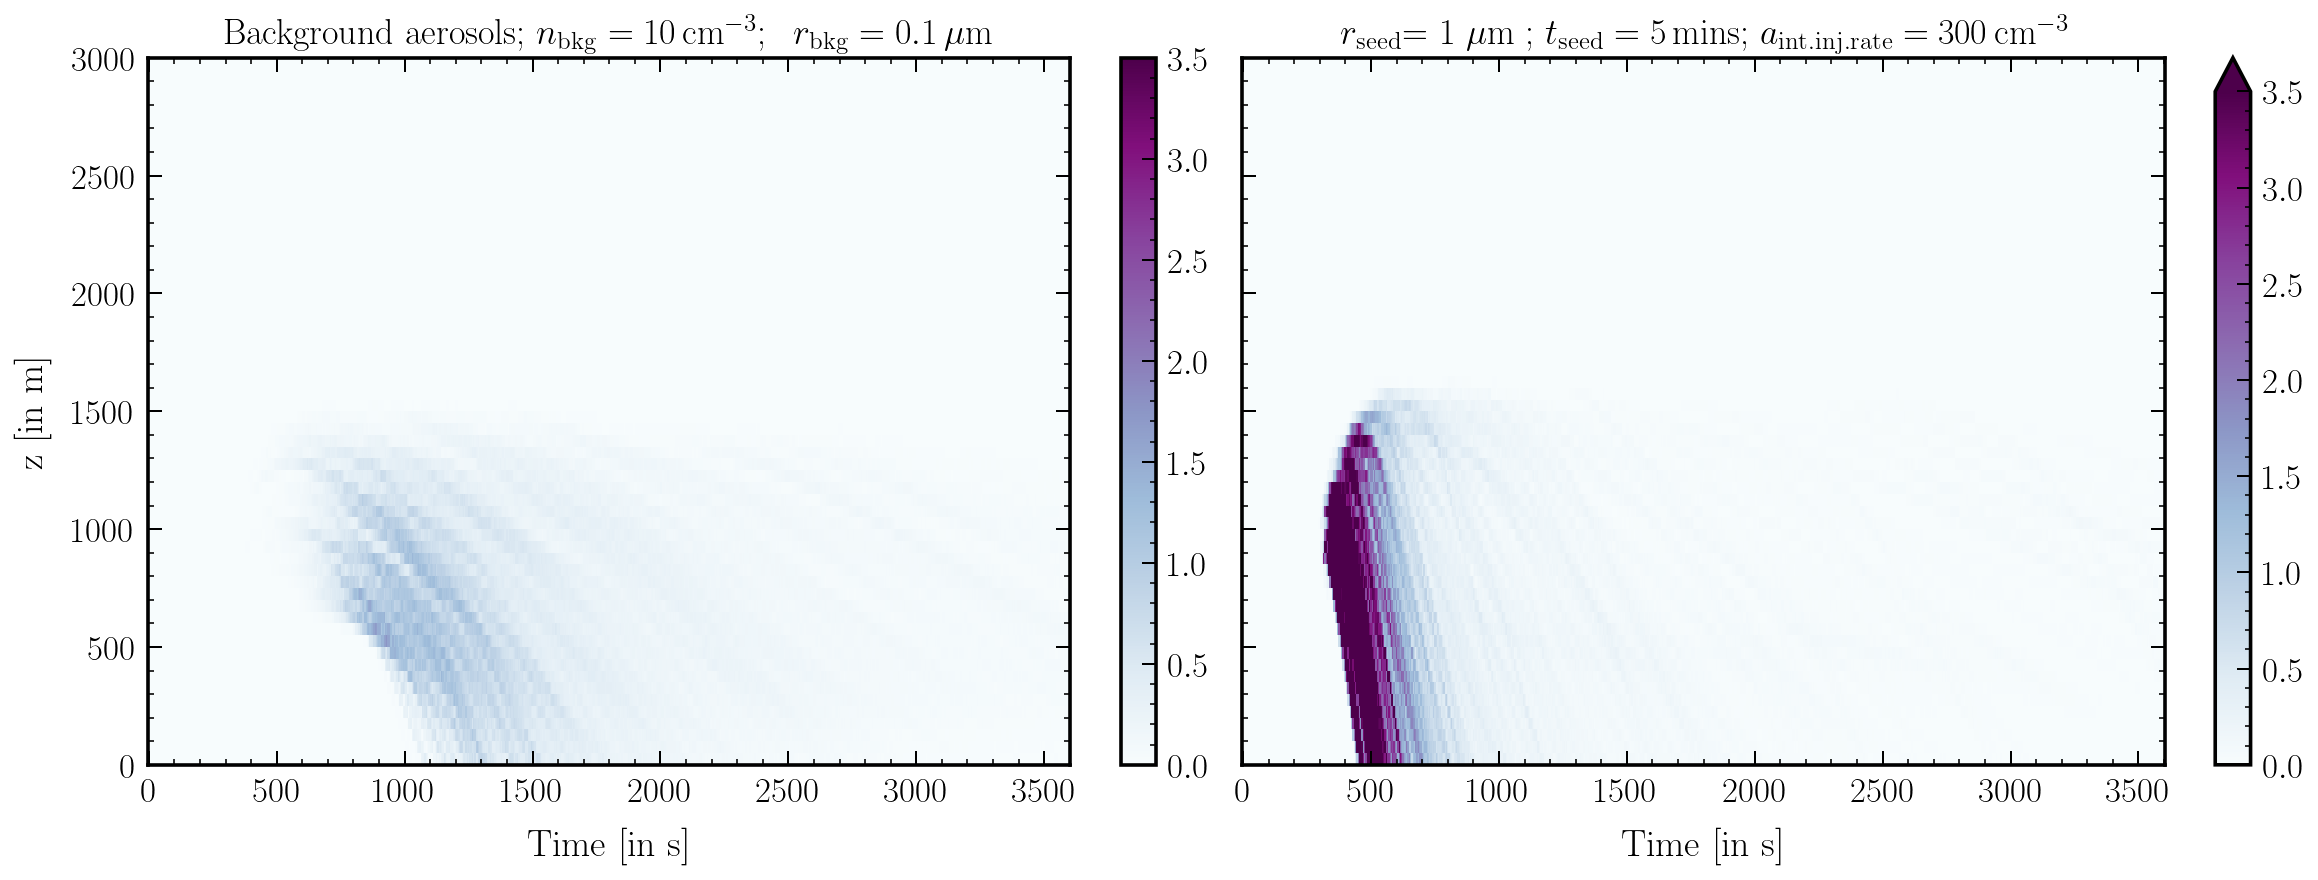

In [61]:
fig, ax= plt.subplots(1, 2, figsize=(16, 6), constrained_layout= True)
surface_rain_bench.mean(dim= "run").plot(ax= ax[0], vmin= 0, vmax= 3.5, cmap= 'BuPu')
surface_rain_seeded.mean(dim= "run").plot(ax= ax[1], vmin= 0, vmax= 3.5, cmap= 'BuPu')
ax[0].set_ylim(0, 3000);
ax[0].set_ylabel(r'z [in m]');
ax[0].set_xlabel(r'Time [in s]');
ax[0].set_title(r'Background aerosols; $n_{\rm bkg} = 10 \, {\rm cm}^{-3}$; \, $r_{\rm bkg} = 0.1 \, \mu {\rm m}$');

ax[1].set_xlabel(r'Time [in s]');
ax[1].set_ylim(0, 3000);
ax[1].set_yticklabels([]);
ax[1].set_ylabel('');
ax[1].set_title(r'$r_{\rm seed}$= 1 $\mu {\rm m}$ ; $t_{\rm seed}= 5 \, {\rm mins}$; $a_{\rm int. inj. rate} = %d \, {\rm cm}^{-3}$'%np.ceil(settings['rhow=2.0_run=0'].int_inj_rate * 1e-6), fontsize= 18);
if sav_flag:
    plt.savefig(sav_plt_path + 'rain_plot_seeding' + sfile_name + '.pdf', dpi= 300);

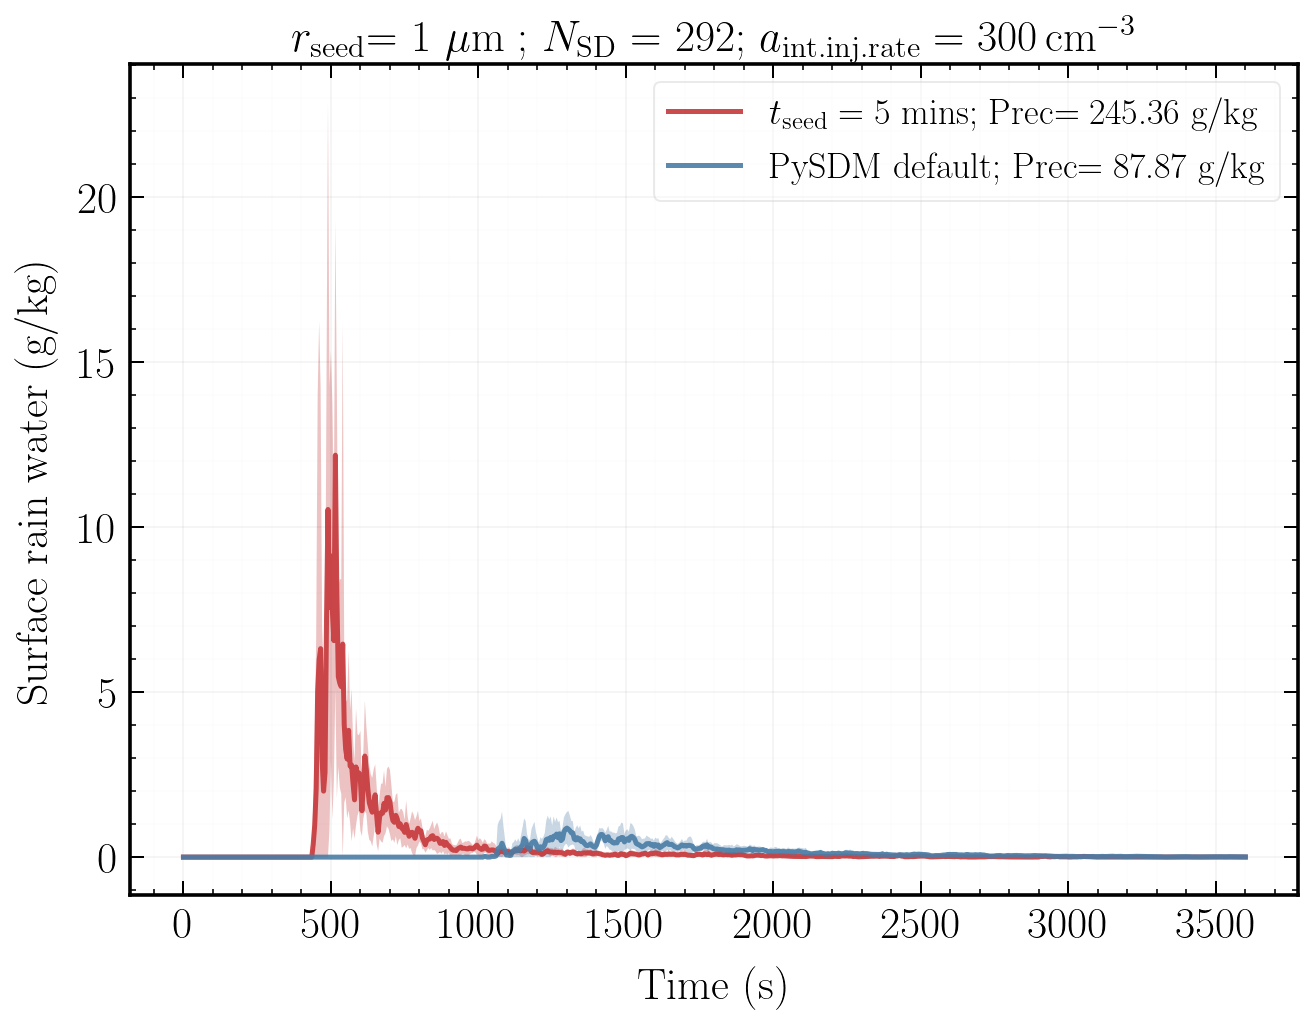

In [64]:
fig, ax= plt.subplots(1, 1, figsize= (9, 7) , constrained_layout= True)
surface_rain_seeded.sel(z= 25).mean(dim= "run").plot(ax= ax, label= r'$t_{\rm seed} = 5 $ mins; Prec= %.2f g/kg'%np.sum(surface_rain_seeded.sel(z= 25).mean(dim= "run").values))
surface_rain_bench.sel(z= 25).mean(dim= "run").plot(ax= ax, label= r'PySDM default; Prec= %.2f g/kg'%np.sum(surface_rain_bench.sel(z= 25).mean(dim= "run").values))
surface_rain_n_seed= surface_rain_bench.sel(z= 25).mean(dim= "run") - surface_rain_bench.sel(z= 25).std(dim= "run")
surface_rain_n_seed[surface_rain_n_seed < 0]= 0
surface_rain_seed= surface_rain_seeded.sel(z= 25).mean(dim= "run") - surface_rain_seeded.sel(z= 25).std(dim= "run")
surface_rain_seed[surface_rain_seed < 0]= 0

ax.fill_between(surface_rain_seeded.t, surface_rain_seeded.sel(z= 25).mean(dim= "run") + surface_rain_seeded.sel(z= 25).std(dim= "run"), surface_rain_seed, alpha= 0.3)
ax.fill_between(surface_rain_bench.t, surface_rain_bench.sel(z= 25).mean(dim= "run") + surface_rain_bench.sel(z= 25).std(dim= "run"), surface_rain_n_seed, alpha= 0.3)
ax.set_xlabel('Time (s)', fontsize= 22);
ax.set_ylabel('Surface rain water (g/kg)', fontsize= 22);
ax.legend(loc= 'upper right', frameon= True, fontsize= 18);

ax.set_title(r'$r_{\rm seed}$= 1 $\mu {\rm m}$ ; $N_{\rm SD}$ = %d; '%simulation['rhow=2.0_run=0'].n_seed_sds + 
                        r'$a_{\rm int. inj. rate} = %d \, {\rm cm}^{-3}$'%np.ceil(settings['rhow=2.0_run=0'].int_inj_rate * 1e-6), fontsize= 22);
ax.tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 22);
ax.grid(visible=True, which='major', color='black', alpha=0.05, linestyle='-');
ax.grid(visible=True, which='minor', color='black', alpha=0.01, linestyle='-');
if sav_flag:
    plt.savefig(sav_plt_path + 'surface_rain_water' + sfile_name + '.pdf', bbox_inches='tight', dpi= 300);

## Experiments

### sandbox 1

In [ ]:
output = {}
settings = {}
simulation = {}
rho_times_w= 2 * si.kg/si.m**3 * si.m/si.s

key = f"rhow={rho_times_w}"
settings[key] = Settings(
        **common_params,
        formulae= Formulae(seed= np.random.randint(1000)),
        rho_times_w_1=rho_times_w,
        precip= True
        )

simulation[key] = Simulation(settings[key])

In [ ]:
simulation[key].save(0)
for i in range(100):
    simulation[key].mpdata.update_advector_field()
    if "Displacement" in simulation[key].particulator.dynamics:
        simulation[key].particulator.dynamics["Displacement"].upload_courant_field(
                (simulation[key].mpdata.advector / simulation[key].g_factor_vec,)
        )
    simulation[key].particulator.run(steps=1)

    simulation[key].save(i+1)

In [ ]:
cell_edge_arr= np.linspace(simulation[key].particulator.attributes['position in cell'].data[0, :].min(), \
                        simulation[key].particulator.attributes['position in cell'].data[0, :].max(), settings[key].nz)
ncell_arr= np.digitize(simulation[key].particulator.attributes['position in cell'].data[0, :], cell_edge_arr) - 1

potseed_arr= np.where(np.abs(simulation[key].particulator.attributes['radius'].data - 1*si.um) < 1*si.um/2)[0]
potindx_arr= np.where((simulation[key].particulator.attributes['position in cell'].data[0, potseed_arr] > 0) \
         & (simulation[key].particulator.attributes['position in cell'][0, potseed_arr] <= 0.25))[0]
potseed= np.random.choice(potseed_arr[potindx_arr], 1)[0]

npotseed_arr= np.where(ncell_arr == ncell_arr[potseed])[0]
npotseed_arr= npotseed_arr[npotseed_arr != potseed]
simulation[key].particulator.attributes['position in cell'].data[0, potseed], simulation[key].particulator.attributes['multiplicity'].data[potseed], \
            simulation[key].particulator.attributes['water mass'].data[potseed]
simulation[key].particulator.attributes['multiplicity'].data[potseed]+= 1e9
simulation[key].particulator.attributes['water mass'].data[npotseed_arr]+= \
                simulation[key].particulator.attributes['water mass'].data[potseed]/len(npotseed_arr)
simulation[key].particulator.attributes['water mass'].data[potseed]= simulation[key].particulator.attributes['water mass'].data[potseed]/len(npotseed_arr)
simulation[key].particulator.attributes['multiplicity'].data[potseed], simulation[key].particulator.attributes['water mass'].data[potseed]

In [ ]:
for i in range(100):
    simulation[key].mpdata.update_advector_field()
    if "Displacement" in simulation[key].particulator.dynamics:
        simulation[key].particulator.dynamics["Displacement"].upload_courant_field(
                (simulation[key].mpdata.advector / simulation[key].g_factor_vec,)
        )
    simulation[key].particulator.run(steps=1)

    simulation[key].save(i+1)

In [ ]:
simulation[key].particulator.attributes['position in cell'].data[0, potseed], simulation[key].particulator.attributes['multiplicity'].data[potseed], \
                simulation[key].particulator.attributes['water mass'].data[potseed]

### sandbox 2

In [ ]:
output = {}
settings = {}
simulation = {}
rho_times_w= 2 * si.kg/si.m**3 * si.m/si.s

key = f"rhow={rho_times_w}"
settings[key] = Settings(
        **common_params,
        formulae= Formulae(seed= np.random.randint(1000)),
        rho_times_w_1=rho_times_w,
        precip= True
        )
simulation[key] = Simulation(settings[key])
output[key]= stepwise_sd_update(simobj= simulation[key], n_steps= settings[key].nt, seed_step= [50, 100, 150, 200], \
                                                                    seed_z_part= settings[key].seed_z_part, seed_r= 1*si.um, seed_m= 1e10, seed_kappa= 0.85)
rain_xarr = {}
rain_xarr[key]= xarray.DataArray(data= output[key].products['rain water mixing ratio'],
                            dims=["z", "t"],
                            coords=dict(
                                t=(["t"], output[key].products['t'],),
                                z=(["z"], output[key].products['z'],),)
                            )

In [ ]:
fig, ax= plt.subplots(1, 1, figsize=(8, 6))
rain_xarr[key].sel(z= 25).plot(ax= ax)
rain_xarr[key].sel(z= 25).sum()